In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
TRAIN_DATA_PATH = "./data-collection/train/"
TEST_DATA_PATH = "./data-collection/test/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

In [3]:
BATCH_SIZE = 20
LEARNING_RATE = 0.001

In [4]:
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
img =next(iter(train_data_loader))
img[0].shape

torch.Size([20, 3, 28, 28])

In [31]:
class my_network_batch_normalization(nn.Module):
    
    # Contructor
    def __init__(self, out_1=8, out_2=16,number_of_classes=4):
        super(my_network_batch_normalization, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(4)
    
    # Prediction
    def forward(self, x):
#         print(x.shape)
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

In [37]:
def train_model(model,n_epochs,train_loader,validation_loader,optimizer):
    
    #global variable 
    N_test=len(test_data)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        total_loss = 0
        count = 0
        for x, y in train_loader:
            count += 1
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_list.append(total_loss/len(train_loader))
        

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            count +=1
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print('Epoch: ', epoch, 'Loss: ', total_loss/len(train_loader), 'Accuracy: ', accuracy)
     
    return accuracy_list, loss_list

In [38]:
# Create the model object using CNN class
model = my_network_batch_normalization(out_1=8, out_2=16)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.6)

In [40]:
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=5,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer)
print('Finished')

Epoch:  0 Loss:  0.5148713685582745 Accuracy:  0.9324583866837388
Epoch:  1 Loss:  0.36201731002178167 Accuracy:  0.9337387964148528
Epoch:  2 Loss:  0.3063814553510329 Accuracy:  0.9379001280409731
Epoch:  3 Loss:  0.27434521085274 Accuracy:  0.93854033290653
Epoch:  4 Loss:  0.25383768838487175 Accuracy:  0.9375800256081946
Finished


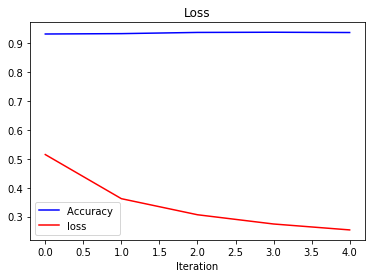

In [41]:
# Plot the loss and accuracy
plt.plot(accuracy_list_normal, 'b', label='Accuracy ')
plt.plot(loss_list_normal, 'r', label='loss')
plt.xlabel('Iteration')
plt.title("Loss")
plt.legend()